In [1]:
from typing import Any, Dict, List, Tuple, Union, Callable, Set
from enum import Enum
from abc import ABC, abstractclassmethod, abstractmethod
import numpy as np
import sympy as sp
import pandas as pd
import tensorflow as tf
from pathlib import Path
import pickle
import os

2024-04-18 11:57:38.291942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 11:57:38.291977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 11:57:38.293346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 11:57:38.300467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 11:57:39.151313: W tensorflow/comp

In [2]:
import string
import re
import json
from functools import partial
import seaborn as sns
from typing import Dict, List
from collections import defaultdict  # For word frequency
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load recipes 

In [4]:
base_path = Path.cwd().parent

In [5]:
df_recipes = pd.read_csv(os.path.join(base_path, 'data', 'df_final_7000.csv'), sep='|', index_col=0)
df_recipes.head(3)

,title,raw_text,cultural_restriction,calories,allergies,recipeId,ingredients,preparation,carbs,fat,fiber,protein,taste,cooking_style,meal_type,prep_time,cuisine,price,ingredients_list
0,Fruit Salad,"1. Fruit Salad: 70 calories per portion, 4 por...",vegan,70.0,contains fruits only,food_0,ingredients:\n- 1 apple\n- 1 banana\n- 1 orang...,\n1. wash and cut all the fruits into bite-siz...,223.0,2.0,0.0,15.0,sweet,mixed,fruit-based,NaN,Fruit Salad - Mixed,2.0,"apple, banana, orange, grape, strawberry, pine..."
1,Vegan Omelette,"5. Vegan Omelette: 300 calories per portion, 1...",vegan,300.0,contains chickpea flour,food_4,ingredients:\n- 1 cup chickpea flour\n- 1 cup ...,"\n1. in a mixing bowl, whisk together the chic...",100.0,20.5,6.0,15.0,Savory,sauteed,veggie,20.0,Vegan Omelette - Vegan,2.0,"chickpea, flour, water, yeast, turmeric, garli..."
2,Vegan French Toast,7. Vegan French Toast: 400 calories per portio...,vegan,400.0,NaN,food_6,ingredients:\n- 4 slices of vegan bread\n- 1 c...,"\n1. in a shallow dish, whisk together the alm...",115.0,38.5,11.8,17.0,sweet,sauteed,vegan,25.0,Vegan French Toast: French,1.0,"vegan, bread, unsweetened, almond, milk, groun..."


In [6]:
# Preprocessing recipes
df_recipes.rename(columns={"allergies": 'allergens'}, inplace=True)

In [7]:
# fill nan in columns
dict_col_nans = {}
for col in df_recipes.columns:
  dict_col_nans[col] = sum(df_recipes[col].isna())

In [8]:
dict_col_nans

{'title': 0,
 'raw_text': 0,
 'cultural_restriction': 805,
 'calories': 0,
 'allergens': 4938,
 'recipeId': 0,
 'ingredients': 0,
 'preparation': 15,
 'carbs': 62,
 'fat': 180,
 'fiber': 735,
 'protein': 120,
 'taste': 1,
 'cooking_style': 779,
 'meal_type': 756,
 'prep_time': 1709,
 'cuisine': 4,
 'price': 0,
 'ingredients_list': 0}

In [9]:
# fill nan
df_recipes['cultural_restriction'].fillna('NotCulturalRestriction', inplace=True)
df_recipes['allergens'].fillna('NotAllergenRegistered', inplace=True)
df_recipes['taste'].fillna('sweet', inplace=True)

In [10]:
mask = df_recipes["ingredients"].isna()
df_recipes_clean = df_recipes[~mask].copy()
sum(df_recipes_clean["ingredients"].isna())
df_recipes_clean["title"] =  df_recipes_clean["title"].apply(lambda x: x.split("\n")[0].strip())
df_recipes_clean.drop_duplicates(subset='title', inplace=True)

## Preprocessing ingredients

In [11]:
list_stop_words = list(set(stopwords.words('english')))
list_measures = ["bag", "bags", "liter", "liters", "bar", "bottle", "bottles", "bowl", "bowls", "box", "boxes", "carton", "jar", "jars",
                 "cup", "cups", "drop", "glass", "piece", "roll", "rolles", "slice", "slices", "spoon", "spoons", "spoonful", "lbs",
                 "all-purpose", "purpose", "diced", "sliced", "shopped","oil",
                 "tablespoon", "tablespoons", "large", "teaspoon", "teaspoons", "tube", "chunks", "chunk", "dice", "dices", "juice", "use", "contains",
                 "contain"]
country_names = ['united','state',  'north', 'america', 'italian', 'mediterranean', 'swiss', 'mexico', 'american', 'middle', 'eastern',
                 'asian', 'usa', 'japan', 'indian', 'moroccan', 'cuban', 'russian', 'japanese', 'british', 'italy',  'greece', 'france',
                 'vietnam', 'turkish', 'holland', 'lebanese', 'belgian', 'india', 'indonesian',  'chilean', 'syrian', 'venezuelan', 'ireland',
                 'swedish', 'filipino', 'polish', 'singaporean', 'israeli', 'brazilian', 'sri', 'lanka', 'jamaican',  'finnish', 'karelian',
                 'afghan',   'nigerian', 'egyptian',     'haitian', 'iraqi', 'maltese', 'algerian', 'canadian',  'ethiopian', 'iranian', 'malaysian',
                 'arabic', 'norwegian', 'brazil', 'belgium', 'russia', 'egypt', 'pakistan', 'dutch', 'african', 'malaysia', 'spain', 'korea', 'lebanon',
                 'tunisian', 'scotland', 'china', 'iran', 'hungarian',  'monterrey', 'latin', 'southern', 'persian', 'argentina', 'albanian', 'scottish',
                 'california', 'israel', 'east',  'spanish', 'irish',  'scandinavia', 'canada',  'southeast', 'asia', 'mongolian',
]
additional_filter = ['optional', 'ripe', 'cooked', 'nutritional', 'chopped', 'cooking', 'powdered', 'serving', 'mixed', 'block','firm',
'drained', 'pressed', 'rinsed', 'melted', 'english', 'type', 'choice', 'pound', 'crumbled','small', 'vital', 'premade', 'scramble', 'tbsp', 'finely',
'sized', 'medium', 'ounce', 'smoke', 'peeled', 'grated', 'pre', 'made', 'based', 'granulated', 'cold', 'cubed', 'add', 'in', 'recipe', 'breakfast',
'mashed', 'free', 'nib', 'active', 'dry', 'softened', 'packed', 'kernel', 'juiced', 'sheet', 'julienned',   'day','old', 'meal', 'tsp', 'stick',
'star', 'inch', 'removed', 'store',  'bought', 'homemade', 'extra',  'least', 'hour', 'refrigerated', 'pocket', 'warm', 'etc', 'shred', 'thick',
'round', 'package', 'shaving', 'plus', 'simple', 'choose','favorite', 'preferred', 'scrambled', 'additional', 'cut', 'strip','paper', 'kind','prefer',
'can', 'overnight','frying','squash', 'apologize', 'language', 'model', 'provide','specific','trained','however','offer','general', 'substituted',
'desired','piece', 'matcha', 'bar', 'added', 'pan', 'crushed',  'calorie','per','portion', 'mixture', 'soft', 'roughly',  'low', 'nutrition',
'colder', 'thin', 'thinning','drizzle', 'suggested', 'energy', 'bite', 'mini', 'desiccated', 'friendly', 'half',  'serve', 'approximately', 'ingredient',
'preparation', 'step',  'listed', 'please', 'note', 'count', 'may', 'vary', 'depending', 'size', 'brand', 'used', 'frosting', 'instant','icing', 'frothing',
'slightly', 'stale', 'dusting', 'approx', 'adjust', 'according', 'whipped', 'heavy', 'crumb', 'includes', 'following', 'total', 'sorry', 'access',
'database', 'tbd', 'dressing', 'quantity', 'best', 'calculate', 'unfortunately', 'ability', 'information', 'like', 'give', 'online', 'tool', 'apps',
'text','directly', 'certainly', 'help', 'varies', 'rough', 'estimate', 'around', 'provides',  'depend', 'amount', 'hulled', 'estimated', 'button', 'fact',
'need', 'make', 'omitted', 'along', 'still', 'real', 'time', 'unable', 'individual', 'exact', 'without', 'knowing',  'consistency', 'beaten', 'culture',
'estimating', 'approximate', 'uncooked', 'average', 'range', 'allergic', 'warning',  'kcals', 'unknown', 'title', 'bay',  'street', 'frank', 'redhot',
'cuisine', 'grilled', 'solid', 'start', 'using', 'grater', 'food', 'processor', 'place', 'clean', 'kitchen', 'towel', 'squeeze', 'excess', 'mixing',
'combine', 'mix', 'well', 'evenly', 'combined', 'heat', 'skillet', 'take', 'form', 'compact', 'heated', 'cook', 'minute', 'side', 'golden', 'remove',
'lined', 'plate', 'absorb', 'repeat', 'process', 'remaining', 'adding', 'divided', 'deep', 'undrained', 'young', 'trimmed', 'thread', 'coloring',
'blanched', 'fried', 'instruction', 'cleaned', 'slider', 'steamed','jumbo', 'full', 'stir', 'fry', 'snap', 'textured', 'bit', 'snow', 'check',  'shape',
'reduction', 'classic', 'sub', 'string', 'metal', 'capability', 'keep', 'mind', 'basic', 'substitute',  'part', 'prepared', 'separately', 'ripened',
'label', 'ring', 'shortening', 'boat', 'ing', 'suitable',  'rehydrated', 'sparkling', 'fermented', 'style',  'ensure', 'required', 'regular', 'necessary',
'allergy', 'giant', 'gigantes', 'diagonally', 'split', 'blended','mild', 'sure', 'ensure', 'required', 'regular', 'necessary', 'allergy','dish','one',
'toothpick', 'generate', 'roasting', 'hard', 'yolk', 'everything', 'coarse', 'trail', 'ready', 'kilogram', 'combination', 'pit', 'flesh', 'mash', 'fork',
'cover', 'plastic', 'pressing', 'onto', 'surface', 'prevent', 'browning', 'refrigerate', 'allow', 'meld', 'let','move', 'depends', 'generally', 'great',
'top', 'marinade', 'rib', 'segmented', 'northern', 'flat', 'people', 'regional', 'influence', 'popular', 'delicious', 'lover', 'preserved', 'end', 'similar',
'see', 'eyed', 'fine', 'century', 'semi', 'johnny', 'recommended', 'calculator', 'determine', 'value',  'traditional', 'typically', 'available', 'kcal',
'able', 'achieve', 'room', 'temperature', 'circular', 'bubble', 'bottom', 'carefully', 'flip', 'another', 'stack', 'follows', 'precooked', 'tongue',
'mentioned', 'replace', 'fermentation', 'center', 'tilt', 'motion', 'appear', 'edge','lift', 'cool', 'bolillos', 'quick', 'easy', 'exception', 'try',
'parfait', 'root', 'loose', 'suggestion', 'thickness', 'fully', 'also', 'known', 'loosely', 'chop', 'could',  'quality', 'slicing', 'increase', 'assist',
'providing', 'prepare', 'grade', 'estimation', 'would', 'data', 'caloric', 'quarter', 'provided', 'list', 'including', 'precise', 'associated','important',
'content', 'number', 'yield', 'know', 'considered', 'segment', 'miniature', 'preheat', 'oven', 'line', 'cutter', 'resembles', 'overmix', 'turn',  'wire',
'rack', 'follow','continue', 'imitation', 'spider', 'allergen', 'caution', 'sensitivity', 'account', 'dietary', 'restriction', 'always', 'adapt',
'accordingly', 'included', 'different', 'none', 'confirm', 'safe', 'potential', 'trigger', 'cause', 'possible', 'intolerance', 'texture', 'sealing', 'exclude',
'dinner', 'club', 'saturated', 'cholesterol', 'carbohydrate', 'fiber', 'factor','idea', 'covered', 'course', 'reduce', 'immersion', 'blender', 'source',
'healthier', 'measurement', 'bomba', 'avoid', 'product', 'present', 'easily', 'adapted', 'accommodate', 'find', 'sure', 'substitution', 'common', 'sharp',
'alternative', 'non', 'dash', 'purpose', 'difficulty', 'intermediate', 'garden', 'intolerant','avoiding', 'skip']

In [12]:
total_stop_words = list_stop_words + list_measures + additional_filter

In [13]:
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def text_preprocessing_nltk(text:str, stop_words:List[str]=None, lema=False, steam=False):
  # 1 lowercase
  new_text = text.lower()
  new_text = re.sub(r"(ingredient|ingredients).*:", " ", new_text)
  # remove numbers
  new_text = re.sub(r"\d+", " ", new_text)
  # 2 Removing puntuation
  new_text = re.sub(r'[^A-Za-z0-9 ]+', ' ', new_text)
  # 3 Tokenization
  words = word_tokenize(new_text)
  # 4 Stop words filtering
  if stop_words:
    filtered_words = [w for w in words if not w in stop_words]
  else:
    filtered_words = words
  # Filtering short words
  filtered_words = list(filter(lambda x: len(x)>2, filtered_words))
  if not lema and not steam:
    return filtered_words
  elif not lema and steam:
    # 5 Stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(w) for w in filtered_words]
    return stemmed
  else:
    # 6 lematization
    lemmatizer = WordNetLemmatizer()
    lemas = [lemmatizer.lemmatize(w) for w in filtered_words]
    return lemas

In [15]:
list_of_words = text_preprocessing_nltk(df_recipes["ingredients"][1], stop_words=total_stop_words, lema=True)
recipe_text = " ".join(list_of_words)
recipe_text

'chickpea flour water yeast turmeric garlic powder onion powder salt pepper taste bell pepper onion tomato fresh cilantro'

In [16]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

## Preprocessing recipes

In [17]:
processing_nltk = partial(text_preprocessing_nltk, stop_words=total_stop_words, lema=True)
recipes_corpus = df_recipes_clean["ingredients"].apply(lambda x: " ".join(processing_nltk(x)))
list_sentences = recipes_corpus.tolist()

In [19]:
import multiprocessing
from gensim.models import Word2Vec, Doc2Vec
import gensim

In [20]:
def generate_corpus(list_sentences: list[str]):
  for sent in list_sentences:
    tokens = gensim.utils.simple_preprocess(sent)
    yield tokens

In [21]:
train_corpus = list(generate_corpus(list_sentences))

In [22]:
len(list_sentences)

6937

In [23]:
word_freq = defaultdict(int)
for sent in list_sentences:
    for i in sent.split(" "):
        word_freq[i] += 1
len(word_freq)

2023

In [24]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['pepper',
 'salt',
 'fresh',
 'taste',
 'onion',
 'garlic',
 'olive',
 'minced',
 'clove',
 'cheese']

In [26]:
bow = list(word_freq.keys())

## Load datasets

In [25]:
train = pd.read_csv(os.path.join(base_path, 'data','train_data.csv'))
print(train.shape)
val = pd.read_csv(os.path.join(base_path, 'data', "val_data.csv"))
print(val.shape)
test = pd.read_csv(os.path.join(base_path, 'data', 'test_data.csv'))
print(test.shape)

(916970, 39)
(229243, 39)
(286554, 39)


## Model utilities 

In [26]:
from tensorflow.keras.layers import (StringLookup,
                                     TextVectorization,
                                     Embedding,
                                     Normalization,
                                     Concatenate,
                                     Flatten,
                                     Dropout,
                                     GlobalAveragePooling1D)
import math

In [27]:
# Mix with the embeddings
def get_embeddings_recipe_id(recipe_id: str, embedding_dict: Dict[str, np.array]):
  return embedding_dict[recipe_id]

In [28]:
# generate features dictionaries
def generate_features(df, feature_list, numeric_features):
  dict_features = {}
  for feature in feature_list:
    #print(f"feature: {feature}")
    if feature in numeric_features:
      #print(f"feature numeric: {feature}")
      dict_features[feature] = tf.convert_to_tensor(df[feature].values, tf.float32, name=f"{feature}")
    else:
      dict_features[feature] = tf.convert_to_tensor(df[feature].values, tf.string, name=f"{feature}")
  return dict_features

In [29]:
# cosine similarity layer
class CosineSimilarity(tf.keras.layers.Layer):
  def __init__(self):
    super(CosineSimilarity, self).__init__()

  def build(self, input_shape):
    pass

  def call(self, inputs):
    x, y = inputs
    dot = tf.reduce_sum(x*y, axis=0)
    #print(f"dot: {dot}")
    norm_x = tf.norm(x, axis=1)
    norm_y = tf.norm(y, axis=1)
    #print(f"norm x: {norm_x}")
    #print(f"norm y: {norm_y}")
    sim = tf.math.divide_no_nan(dot, norm_x*norm_y)
    return tf.expand_dims(sim, axis=0)

In [30]:
def create_model_inputs(feature_names: List[str],
                        numeric_features: List[str],
                        shapes_dict: Dict[str, Tuple] = None):
    inputs = {}
    for feature_name in feature_names:
      shape = ()
      if shapes_dict is not None and feature_name in shapes_dict.keys():
        shape = shapes_dict[feature_name]
      if feature_name in numeric_features:
          inputs[feature_name] = tf.keras.layers.Input(
              name=feature_name, shape=shape, dtype=tf.float32
          )
      else:
          inputs[feature_name] = tf.keras.layers.Input(
              name=feature_name, shape=shape, dtype=tf.string
          )
    return inputs

In [31]:
import string

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

In [32]:
from keras.src.metrics.confusion_metrics import activations
from keras.src.utils.feature_space import Feature
from tensorflow.python.eager import context
def encode_inputs(inputs, categorical_dict, user_features, recipes_features=[], context_features=[]):
    encoded_features = []
    user_features_list = []
    recipes_features_list = []
    context_features_list = []
    for feature_name in inputs:
      # check if the input is in the list
      if feature_name in user_features_list or feature_name in recipes_features or context_features in context_features:
        print(f"Processing feature: {feature_name}...")
        if feature_name in categorical_dict:
            embedding_type = categorical_dict.get(feature_name)
            if embedding_type is not None:
                if embedding_type["embedding_type"] == "text":
                    # Vocabulary size and number of words in a sequence.
                    vocab_size = 10000
                    sequence_length = embedding_type.get("max_seq_len", 10)
                    # Use the text vectorization layer to normalize, split, and map strings to
                    # integers. Note that the layer uses the custom standardization defined above.
                    # Set maximum_sequence length as all samples are not of the same length.
                    text_dataset = \
                    tf.data.Dataset.from_tensor_slices(
                        np.expand_dims(train[feature_name].to_numpy().astype(str), -1)
                        )
                    vectorize_layer = tf.keras.layers.TextVectorization(
                        standardize=custom_standardization,
                        max_tokens=vocab_size,
                        output_mode='int',
                        output_sequence_length=10
                    )
                    vectorize_layer.adapt(text_dataset.batch(64))
                    vectorized_text = vectorize_layer(inputs[feature_name])
                    embedding_text = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=100,
                                                mask_zero=True)(vectorized_text)
                    flatten_layer = tf.keras.layers.Flatten()
                    encoded_feature = flatten_layer(embedding_text)
                else:
                    vocabulary = categorical_dict[feature_name]["vocabulary"]
                    # Create a lookup to convert string values to an integer indices.
                    # Since we are not using a mask token nor expecting any out of vocabulary
                    # (oov) token, we set mask_token to None and  num_oov_indices to 0.
                    if embedding_type["embedding_type"] == "sparse":
                        use_embedding = False
                    else:
                        use_embedding = True
                    lookup = StringLookup(
                    vocabulary=vocabulary,
                    mask_token=None,
                    num_oov_indices=0,
                    output_mode="int" if use_embedding else "binary",
                    )
                    if use_embedding:
                        # Convert the string input values into integer indices.
                        encoded_feature = lookup(inputs[feature_name])
                        embedding_dims = int(math.sqrt(len(vocabulary)))
                        # Create an embedding layer with the specified dimensions.
                        embedding = tf.keras.layers.Embedding(
                            input_dim=len(vocabulary), output_dim=embedding_dims
                        )
                        # Convert the index values to embedding representations.
                        encoded_feature = embedding(encoded_feature)
                    else:
                        # Convert the string input values into a one hot encoding.
                        encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            data = tf.data.Dataset.from_tensor_slices(
                np.expand_dims(train[feature_name].to_numpy().astype(np.float32), -1))
            normalization_layer = Normalization(axis=-1, input_dim=1)
            normalization_layer.adapt(data, steps=40)
            encoded_feature = normalization_layer(tf.expand_dims(inputs[feature_name], -1))
            #encoded_feature = tf.expand_dims(inputs[feature_name], -1)
        # create submodels
        if feature_name in user_features:
          user_features_list.append(encoded_feature)
        elif len(recipes_features) > 0 and feature_name in recipes_features:
          recipes_features_list.append(encoded_feature)
        elif len(context_features) > 0:
          context_features_list.append(encoded_feature)
        else:
          pass

    # create submodels
    # user sub model
    user_concat = tf.keras.layers.concatenate(user_features_list)
    user_concat = tf.keras.layers.Dense(units=100, activation="linear",
                                 kernel_regularizer="l2",
                               name="user_embedding")(user_concat)
    # recipes sub model
    if len(recipes_features) > 0:
      recipes_concat = tf.keras.layers.concatenate(recipes_features_list)
      recipes_concat = tf.keras.layers.Dense(units=100, activation="linear",
                                  kernel_regularizer="l2",
                                    name="recipes_embedding")(recipes_concat)
    else:
      recipes_concat = None

    # context sub model
    if len(context_features) > 0:
      context_concat = tf.keras.layers.concatenate(context_features_list)
      context_concat = tf.keras.layers.Dense(units=32, activation="linear",
                                  kernel_regularizer="l2",
                                    name="context_embedding")(context_concat)
    else:
      context_concat = None

    #all_features = layers.concatenate([user_concat, recipes_concat, context_concat])
    #all_features = Concatenate()(encoded_features)
    return user_concat, recipes_concat, context_concat

In [33]:
def encode_features(model_inputs, feature_list,
                    categorical_dict,
                    numerical_features,
                    final_layer_size=100,
                    layer_name = 'concat_layer',
                    embedding_list = None,
                    defined_input_shape=False):
  encoded_features_list = []
  for feature_name in feature_list:
    # check if the input is in the list
    print(f"Processing feature: {feature_name}...")
    if feature_name in categorical_dict:
      embedding_type = categorical_dict.get(feature_name)
      if embedding_type is not None:
        if embedding_type["embedding_type"] == "text":
          # Vocabulary size and number of words in a sequence.
          vocab_size = 10000
          sequence_length = embedding_type.get("max_seq_len", 10)
          # Use the text vectorization layer to normalize, split, and map strings to
          # integers. Note that the layer uses the custom standardization defined above.
          # Set maximum_sequence length as all samples are not of the same length.
          text_dataset = \
          tf.data.Dataset.from_tensor_slices(
              np.expand_dims(train[feature_name].to_numpy().astype(str), -1)
              )
          vectorize_layer = tf.keras.layers.TextVectorization(
              standardize=custom_standardization,
              max_tokens=vocab_size,
              output_mode='int',
              output_sequence_length=10
          )
          vectorize_layer.adapt(text_dataset.batch(64))
          vectorized_text = vectorize_layer(model_inputs[feature_name])
          embedding_text = tf.keras.layers.Embedding(input_dim=vocab_size,
                                      output_dim=100,
                                      mask_zero=True)(vectorized_text)
          flatten_layer = tf.keras.layers.Flatten()
          encoded_feature = flatten_layer(embedding_text)
        else:
          vocabulary = categorical_dict[feature_name]["vocabulary"]
          # Create a lookup to convert string values to an integer indices.
          # Since we are not using a mask token nor expecting any out of vocabulary
          # (oov) token, we set mask_token to None and  num_oov_indices to 0.
          if embedding_type["embedding_type"] == "sparse":
              use_embedding = False
          else:
              use_embedding = True
          lookup = StringLookup(
          vocabulary=vocabulary,
          mask_token=None,
          num_oov_indices=0,
          output_mode="int" if use_embedding else "binary",
          )
          if use_embedding:
              # Convert the string input values into integer indices.
              encoded_feature = lookup(model_inputs[feature_name])
              embedding_dims = int(math.sqrt(len(vocabulary)))
              # Create an embedding layer with the specified dimensions.
              embedding = tf.keras.layers.Embedding(
                  input_dim=len(vocabulary), output_dim=embedding_dims
              )
              # Convert the index values to embedding representations.
              encoded_feature = embedding(encoded_feature)
              # Flatten the embedding layer to a 1D tensor.
              if defined_input_shape:
                encoded_feature = tf.keras.layers.Flatten()(encoded_feature)
          else:
              # Convert the string input values into a one hot encoding.
              if defined_input_shape:
                encoded_feature = lookup(model_inputs[feature_name])
              else:
                encoded_feature = lookup(tf.expand_dims(model_inputs[feature_name], -1))
    else:
      # Use the numerical features as-is.
      # data = tf.data.Dataset.from_tensor_slices(
      #     np.expand_dims(train[feature_name].to_numpy().astype(np.float32), -1))
      # normalization_layer = Normalization(input_shape=(1,))
      # normalization_layer.adapt(data, steps=40)
      # encoded_feature = normalization_layer(tf.expand_dims(model_inputs[feature_name], -1))
      if embedding_list is not None:
        if feature_name in embedding_list:
          encoded_feature = model_inputs[feature_name]
        else:
          if defined_input_shape:
            encoded_feature = model_inputs[feature_name]
          else:
            encoded_feature = tf.expand_dims(model_inputs[feature_name], -1)
      else:
        if defined_input_shape:
          encoded_feature = model_inputs[feature_name]
        else:
          encoded_feature = tf.expand_dims(model_inputs[feature_name], -1)
    encoded_features_list.append(encoded_feature)
  all_features = tf.keras.layers.concatenate(encoded_features_list)
  all_features = tf.keras.layers.Dense(units=final_layer_size,
                              activation="linear",
                              kernel_regularizer="l2",
                              name=layer_name)(all_features)
  return all_features

## Load embeddings

In [34]:
path = os.path.join(base_path, 'data', 'full_recipes_sentence_embedding_USE_v2.npz')
dict_embeddings_cbow = dict(np.load(path))

### Dataset preprocessing with embeddings

In [35]:
mask_train = train["foodId"].isin(list(dict_embeddings_cbow.keys()))
filtered_train =train.loc[mask_train, :]
mask_val = val["foodId"].isin(list(dict_embeddings_cbow.keys()))
filtered_val = val.loc[mask_val, :]
mask_test = test["foodId"].isin(list(dict_embeddings_cbow.keys()))
filtered_test = test.loc[mask_test, :]

In [36]:
user_features_list = ['nutrition_goal', 'clinical_gender', 'age_range',
                      'life_style', 'weight', 'height',
                      'projected_daily_calories', 'current_daily_calories',
                      'cultural_factor', 'allergy',
                      'current_working_status', 'marital_status', 'ethnicity',
                      'BMI', 'next_BMI']
#food_features = ['recipe_name', 'recipe_raw_text', 'meal_type_y',
#      'food_cultural_class', 'calories', 'allergens', 'recipeId']
food_features = ['food_cultural_class', 'calories', 'allergens', 'taste', 'price', 'recipeId']
context_features  = ['day_number', 'meal_type_y','time_of_meal_consumption', 'place_of_meal_consumption', 'social_situation_of_meal_consumption']
label_list = ['label']

In [37]:
def generate_supervision(vector_row: np.array):
  index = np.argmax(vector_row)
  if index < 2:
    return 0.0
  else:
    return 1.0

In [38]:
filtered_train.loc[:, "label"] = filtered_train[['label__Never', 'label__Avoidable', 'label__Neutral',
                'label__Favorable', 'label__Appreciated']].apply(lambda row: generate_supervision(row.to_numpy()), axis=1)
filtered_val.loc[:, "label"] = filtered_val[['label__Never', 'label__Avoidable', 'label__Neutral',
                'label__Favorable', 'label__Appreciated']].apply(lambda row: generate_supervision(row.to_numpy()), axis=1)
filtered_test.loc[:, "label"] = filtered_test[['label__Never', 'label__Avoidable', 'label__Neutral',
                'label__Favorable', 'label__Appreciated']].apply(lambda row: generate_supervision(row.to_numpy()), axis=1)

/tmp/ipykernel_3356214/879706689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train.loc[:, "label"] = filtered_train[['label__Never', 'label__Avoidable', 'label__Neutral',
/tmp/ipykernel_3356214/879706689.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_val.loc[:, "label"] = filtered_val[['label__Never', 'label__Avoidable', 'label__Neutral',
/tmp/ipykernel_3356214/879706689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

### Join recipes and data

In [39]:
filtered_train = filtered_train[[
    'day_number', 'meal_type_x', 'userId', 'foodId',
    'time_of_meal_consumption', 'place_of_meal_consumption',
    'social_situation_of_meal_consumption', 'nutrition_goal',
    'clinical_gender', 'age_range', 'life_style', 'weight', 'height',
       'projected_daily_calories', 'current_daily_calories',
       'country_of_origin', 'living_country', 'current_location',
       'cultural_factor', 'probabilities', 'allergy', 'Multi-allergy',
       'current_working_status', 'marital_status', 'ethnicity', 'BMI',
       'next_BMI', 'recipe_name', 'recipe_raw_text', 'meal_type_y',
       'food_cultural_class', 'recipeId',
       'label__Appreciated', 'label__Avoidable', 'label__Favorable',
       'label__Neutral', 'label__Never', 'label'
]]
filtered_val = filtered_val[[
    'day_number', 'meal_type_x', 'userId', 'foodId',
    'time_of_meal_consumption', 'place_of_meal_consumption',
    'social_situation_of_meal_consumption', 'nutrition_goal',
    'clinical_gender', 'age_range', 'life_style', 'weight', 'height',
       'projected_daily_calories', 'current_daily_calories',
       'country_of_origin', 'living_country', 'current_location',
       'cultural_factor', 'probabilities', 'allergy', 'Multi-allergy',
       'current_working_status', 'marital_status', 'ethnicity', 'BMI',
       'next_BMI', 'recipe_name', 'recipe_raw_text', 'meal_type_y',
       'food_cultural_class', 'recipeId',
       'label__Appreciated', 'label__Avoidable', 'label__Favorable',
       'label__Neutral', 'label__Never', 'label'
]]
filtered_test = filtered_test[[
    'day_number', 'meal_type_x', 'userId', 'foodId',
    'time_of_meal_consumption', 'place_of_meal_consumption',
    'social_situation_of_meal_consumption', 'nutrition_goal',
    'clinical_gender', 'age_range', 'life_style', 'weight', 'height',
       'projected_daily_calories', 'current_daily_calories',
       'country_of_origin', 'living_country', 'current_location',
       'cultural_factor', 'probabilities', 'allergy', 'Multi-allergy',
       'current_working_status', 'marital_status', 'ethnicity', 'BMI',
       'next_BMI', 'recipe_name', 'recipe_raw_text', 'meal_type_y',
       'food_cultural_class', 'recipeId',
       'label__Appreciated', 'label__Avoidable', 'label__Favorable',
       'label__Neutral', 'label__Never', 'label'
]]

In [40]:
filtered_train_join = pd.merge(filtered_train,
                               df_recipes_clean[['calories', 'allergens', 'taste', 'price', 'recipeId']],
                               on='recipeId')
filtered_val_join = pd.merge(filtered_val,
                               df_recipes_clean[['calories', 'allergens', 'taste', 'price', 'recipeId']],
                               on='recipeId')
filtered_test_join = pd.merge(filtered_test,
                               df_recipes_clean[['calories', 'allergens', 'taste', 'price', 'recipeId']],
                               on='recipeId')

## Filter out users for study evaluation

In [41]:
# unique users
unique_user_id = np.unique(filtered_train_join['userId'])
np.random.seed(0)
selected_test_user_id = np.random.choice(unique_user_id, size=50)
user_based_filtered_train =  filtered_train_join.query("userId not in @selected_test_user_id")
val_users_id = selected_test_user_id[:25]
test_users_id = selected_test_user_id[25:]
user_based_filtered_val =  filtered_val_join.query("userId not in @test_users_id")
user_based_filtered_test = filtered_test_join

## Join preprocessed datasets

In [42]:
total_columns = user_features_list+context_features+food_features+label_list
preprossed_df = user_based_filtered_train[total_columns]
preprossed_df_val = user_based_filtered_val[total_columns]
preprossed_df_test = user_based_filtered_test[total_columns]
print(preprossed_df.columns)

Index(['nutrition_goal', 'clinical_gender', 'age_range', 'life_style',
       'weight', 'height', 'projected_daily_calories',
       'current_daily_calories', 'cultural_factor', 'allergy',
       'current_working_status', 'marital_status', 'ethnicity', 'BMI',
       'next_BMI', 'day_number', 'meal_type_y', 'time_of_meal_consumption',
       'place_of_meal_consumption', 'social_situation_of_meal_consumption',
       'food_cultural_class', 'calories', 'allergens', 'taste', 'price',
       'recipeId', 'label'],
      dtype='object')


In [43]:
# Cbow embeddings
# get_recipe_emb = partial(get_embeddings_recipe_id, embedding_dict=dict_embeddings_cbow)
# skipgram embeddings
get_recipe_emb = partial(get_embeddings_recipe_id, embedding_dict=dict_embeddings_cbow)

In [44]:
# Set embeddings 
preprossed_df.loc[:, "embeddings"] = preprossed_df["recipeId"].apply(lambda x: get_recipe_emb(x))
preprossed_df_val.loc[:, "embeddings"] = preprossed_df_val["recipeId"].apply(lambda x: get_recipe_emb(x))
preprossed_df_test.loc[:, "embeddings"] = preprossed_df_test["recipeId"].apply(lambda x: get_recipe_emb(x))


/tmp/ipykernel_3356214/2342519484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprossed_df.loc[:, "embeddings"] = preprossed_df["recipeId"].apply(lambda x: get_recipe_emb(x))
/tmp/ipykernel_3356214/2342519484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprossed_df_val.loc[:, "embeddings"] = preprossed_df_val["recipeId"].apply(lambda x: get_recipe_emb(x))
/tmp/ipykernel_3356214/2342519484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

## Load trained model 

In [45]:
path = os.path.join(base_path, 'models', 
                    "training_model_0_use_full_inputs_user_food_context_input_shape.tf-20240403T081741Z-001/training_model_0_use_full_inputs_user_food_context_input_shape.tf")
model_context_m1 = tf.keras.models.load_model(path)

## Prepare the inputs 

In [46]:
df_join_dataset = filtered_train_join
food_features

['food_cultural_class', 'calories', 'allergens', 'taste', 'price', 'recipeId']

In [47]:
CATEGORICAL_FEATURES_DICT = {
'taste': {"embedding_type": "sparse", "vocabulary":
    list(df_join_dataset['taste'].unique())},
'allergens': {"embedding_type": "dense", "vocabulary":
    list(df_join_dataset['allergens'].unique())},
'meal_type_y': {"embedding_type": "sparse", "vocabulary":
    list(df_join_dataset['meal_type_y'].unique())},
 'userId': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['userId'].unique())},
  'recipeId': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['recipeId'].unique())},
 'foodId': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['foodId'].unique())},
 'place_of_meal_consumption': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['place_of_meal_consumption'].unique())},
 'social_situation_of_meal_consumption': {"embedding_type": "dense", "vocabulary":
    list(df_join_dataset['social_situation_of_meal_consumption'].unique())},
 'nutrition_goal': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['nutrition_goal'].unique())},
 'clinical_gender': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['clinical_gender'].unique())},
 'age_range': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['age_range'].unique())},
 'life_style': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['life_style'].unique())},
 'country_of_origin': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['country_of_origin'].unique())},
 'living_country': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['living_country'].unique())},
 'cultural_factor': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['cultural_factor'].unique())},
 'probabilities': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['probabilities'].unique())},
 'allergy': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['allergy'].unique())},
 'current_working_status': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['current_working_status'].unique())},
 'marital_status': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['marital_status'].unique())},
 'ethnicity': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['ethnicity'].unique())},
 'BMI': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['BMI'].unique())},
 'next_BMI': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['next_BMI'].unique())},
 'recipe_name': {"embedding_type": "text", "vocabulary":
     list(df_join_dataset['recipe_name'].unique()),
     "max_seq_len": 5},
 'recipe_raw_text': {"embedding_type": "text", "vocabulary":
     list(df_join_dataset['recipe_raw_text'].unique()),
     "max_seq_len": 10},
 'food_cultural_class': {"embedding_type": "dense", "vocabulary":
     list(df_join_dataset['food_cultural_class'].unique())}
#  'allergens': {"embedding_type": "text", "vocabulary":
#      list(df_join_dataset['allergens'].unique()),
#      "max_seq_len": 10}
}

In [48]:
numeric_features = ['weight',
                    'height',
                    'projected_daily_calories',
                    'current_daily_calories',
                    'day_number',
                    'time_of_meal_consumption',
                    'calories', 'embeddings',
                    'price']

In [49]:
np.array(preprossed_df["embeddings"].tolist()).shape

(594380, 512)

In [50]:
model_inputs = model_context_m1.inputs
for inpt in model_inputs:
  print(inpt)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='BMI'), name='BMI', description="created by layer 'BMI'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='age_range'), name='age_range', description="created by layer 'age_range'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='allergens'), name='allergens', description="created by layer 'allergens'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='allergy'), name='allergy', description="created by layer 'allergy'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='calories'), name='calories', description="created by layer 'calories'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='clinical_gender'), name='clinical_gender', description="created by layer 'clinical_gender'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='cultural_factor'), name='cultural_factor', desc

In [51]:
# model inputs
tf.keras.utils.plot_model(model_context_m1, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Prepare the model inputs 

In [52]:
input_features = ['nutrition_goal',
 'clinical_gender',
 'age_range',
 'life_style',
 'weight',
 'height',
 'projected_daily_calories',
 'current_daily_calories',
 'cultural_factor',
 'allergy',
 'current_working_status',
 'marital_status',
 'ethnicity',
 'BMI',
 'next_BMI',
 'day_number',
 'meal_type_y',
 'time_of_meal_consumption',
 'place_of_meal_consumption',
 'social_situation_of_meal_consumption',
 'food_cultural_class',
 'calories',
 'allergens',
 'taste',
 'price',
  'embeddings']

In [53]:
shape = (np.array(preprossed_df["embeddings"].tolist()).shape[1])
print(shape)
#full_user_emb = np.vstack(list(dict_users_embeddings.values()))
full_recipe_emb = np.vstack(list(dict_embeddings_cbow.values()))

512


## Generate Dataset from pandas 

In [54]:
def generate_dataset_from_pandas(df:pd.DataFrame, numeric_features, feature_columns, embedding_columns, target_col):
  dict_features = generate_features(df, feature_columns, numeric_features)
  dict_embeddings = {}
  for emb_col in embedding_columns:
    dict_embeddings[emb_col] = tf.convert_to_tensor(np.array(df.loc[:, emb_col].tolist()), dtype=tf.float32)
  dict_features.update(dict_embeddings)
  #dict_labels = generate_features(train, TARGET_FEATURE_LABELS, TARGET_FEATURE_LABELS)
  labels = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(df.loc[:, target_col].values, dtype=tf.float32))
  features = tf.data.Dataset.from_tensor_slices(dict_features)
  # embeddings_ds = tf.data.Dataset.from_tensor_slices(dict_features)
  # features_ds = tf.data.Dataset.zip((features, embeddings_ds))
  ds = tf.data.Dataset.zip((features, labels))
  #train_ds = tf.data.Dataset.from_tensor_slices((features_list, labels_list))
  return ds

In [55]:
input_features_without_emb = ['BMI',
 'age_range',
 'allergens',
 'allergy',
 'calories',
 'clinical_gender',
 'cultural_factor',
 'current_daily_calories',
 'current_working_status',
 'day_number',
 'ethnicity',
 'food_cultural_class',
 'height',
 'life_style',
 'marital_status',
 'meal_type_y',
 'next_BMI',
 'nutrition_goal',
 'place_of_meal_consumption',
 'price',
 'projected_daily_calories',
 'social_situation_of_meal_consumption',
 'taste',
 'time_of_meal_consumption',
 'weight']

In [56]:
def transform_to_float(text: str):
  value = re.findall(r'\d', text)
  if len(value) == 0:
    return 2.0
  else:
    return float(value[0])

In [57]:
preprossed_df['price'] =preprossed_df['price'].apply(lambda x: transform_to_float(x))
preprossed_df_val['price'] = preprossed_df_val['price'].apply(lambda x: transform_to_float(x))
preprossed_df_test['price'] = preprossed_df_test['price'].apply(lambda x: transform_to_float(x))

/tmp/ipykernel_3356214/1025819399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprossed_df['price'] =preprossed_df['price'].apply(lambda x: transform_to_float(x))
/tmp/ipykernel_3356214/1025819399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprossed_df_val['price'] = preprossed_df_val['price'].apply(lambda x: transform_to_float(x))
/tmp/ipykernel_3356214/1025819399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [58]:
train_ds = generate_dataset_from_pandas(preprossed_df.sample(frac=1),
                                        numeric_features,
                                        feature_columns=input_features_without_emb,
                                        embedding_columns=["embeddings"],
                                        target_col="label")

2024-04-18 17:15:25.279099: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1217290240 exceeds 10% of free system memory.


In [59]:
val_ds = generate_dataset_from_pandas(preprossed_df_val.sample(frac=1),
                                      numeric_features,
                                      feature_columns=input_features_without_emb,
                                      embedding_columns=["embeddings"],
                                      target_col="label")

2024-04-18 17:15:31.064887: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320282624 exceeds 10% of free system memory.


In [60]:
test_ds = generate_dataset_from_pandas(preprossed_df_test,
                                      numeric_features,
                                      feature_columns=input_features_without_emb,
                                      embedding_columns=["embeddings"],
                                      target_col="label")

2024-04-18 17:15:34.721664: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419956736 exceeds 10% of free system memory.


In [61]:
# check embeddings and batch
train_ds = train_ds.batch(batch_size=128).shuffle(1024)
val_ds = val_ds.batch(batch_size=128).shuffle(1024)
test_ds = test_ds.batch(128)

## Model evaluation 

In [62]:
# eval
y_test_pred_raw = model_context_m1.predict(test_ds)
y_test_pred = np.rint(y_test_pred_raw)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

2024-04-18 17:15:41.368553: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419956736 exceeds 10% of free system memory.


1603/1603 [==============================] - 8s 5ms/step


In [63]:
print(classification_report(y_true, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    102919
         1.0       0.98      0.99      0.99    102138

    accuracy                           0.99    205057
   macro avg       0.99      0.99      0.99    205057
weighted avg       0.99      0.99      0.99    205057



In [64]:
precision_test = precision_score(y_true, y_test_pred)
recall_test = recall_score(y_true, y_test_pred)

print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")

Precision: 0.9846833751207281
Recall: 0.9882022361902524


In [65]:
# confusion matrix
cnf = confusion_matrix(y_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf, display_labels=["dislike", "like"])

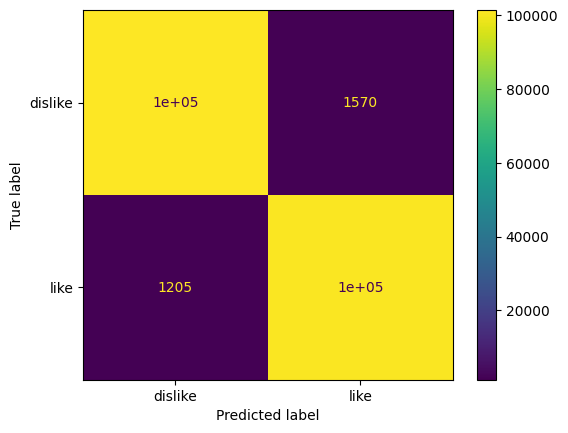

In [66]:
disp.plot()

## Extract rules from the model 

In [67]:
train_ds = generate_dataset_from_pandas(preprossed_df.sample(frac=1),
                                        numeric_features,
                                        feature_columns=input_features_without_emb,
                                        embedding_columns=["embeddings"],
                                        target_col="label")

2024-04-18 17:17:13.276528: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1217290240 exceeds 10% of free system memory.


In [68]:
train_ds = train_ds.batch(128)

In [69]:
feature_names = [f"emb_{i}" for i in range(0, 700)]

In [70]:
class_names = [0, 1]

In [71]:
y_train_pred = model_context_m1.predict(train_ds)

4644/4644 [==============================] - 23s 5ms/step


In [72]:
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))

In [74]:
from dexire.dexire import DEXiRE

In [75]:
dexire = DEXiRE(model=model_context_m1,
                feature_names=feature_names,
                class_names=class_names)

In [76]:
rules = dexire.extract_rules(train_ds, layer_idx=-6)

   1/4644 [..............................] - ETA: 1:01

4644/4644 [==============================] - 22s 5ms/step
Number of classes: [0. 1.]
4644/4644 [==============================] - 20s 4ms/step
318
emb_318
318
emb_318
318
emb_318
318
emb_318
185
emb_185
318
emb_318
182
emb_182
497
emb_497
396
emb_396
396
emb_396
396
emb_396


In [77]:
# count total terms
total = 0
for rule in rules.rules:
  print(rule.premise)
  total += len(rule.premise.clauses)
print(total)

((emb_318 > -0.191) AND (emb_396 <= 0.183) AND (emb_396 <= 0.152) AND (emb_396 <= 0.125))
((emb_318 <= -0.191) AND (emb_318 <= -0.235) AND (emb_318 <= -0.271) AND (emb_318 <= -0.297) AND (emb_185 > -5.722) AND (emb_318 <= -0.325) AND (emb_182 <= 24.713) AND (emb_497 > -1.245))
((emb_318 <= -0.191) AND (emb_318 > -0.235))
((emb_318 <= -0.191) AND (emb_318 <= -0.235) AND (emb_318 <= -0.271) AND (emb_318 <= -0.297) AND (emb_185 > -5.722) AND (emb_318 <= -0.325) AND (emb_182 <= 24.713) AND (emb_497 <= -1.245))
((emb_318 <= -0.191) AND (emb_318 <= -0.235) AND (emb_318 > -0.271))
((emb_318 <= -0.191) AND (emb_318 <= -0.235) AND (emb_318 <= -0.271) AND (emb_318 <= -0.297) AND (emb_185 > -5.722) AND (emb_318 > -0.325))
((emb_318 > -0.191) AND (emb_396 <= 0.183) AND (emb_396 <= 0.152) AND (emb_396 > 0.125))
((emb_318 <= -0.191) AND (emb_318 <= -0.235) AND (emb_318 <= -0.271) AND (emb_318 > -0.297))
((emb_318 > -0.191) AND (emb_396 <= 0.183) AND (emb_396 > 0.152))
((emb_318 <= -0.191) AND (emb_3

In [78]:
# Save rules 
with open('rules_use.pkl', 'bw') as f:
    pickle.dump(rules, f, pickle.HIGHEST_PROTOCOL)

In [79]:
def get_intermediate_model(full_model, layer_idx):
  intermediate_layer_model = tf.keras.models.Model(inputs=full_model.input,
                                 outputs=full_model.layers[layer_idx].output)
  return intermediate_layer_model

In [80]:
partial_model = get_intermediate_model(model_context_m1, -6)

In [81]:
x_test = partial_model.predict(test_ds)

1603/1603 [==============================] - 7s 4ms/step


In [82]:
rows = np.random.choice(len(x_test), 1000)
x_test = x_test[rows]
y_true = y_true[rows]
y_test_pred = y_test_pred[rows]

In [83]:
y_rs = rules.predict(x_test)

In [84]:
y_rs_np = np.zeros_like(y_true)
for i in range(len(y_rs_np)):
  if y_rs[i][0][-1] == "1":
    y_rs_np[i] = 1

In [85]:
np.unique(y_rs)

array(['class: 0', 'class: 1'], dtype='<U8')

In [86]:
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

In [87]:
acc = accuracy_score(y_true, y_rs_np)
fiderlity = accuracy_score(y_test_pred, y_rs_np)
precision = precision_score(y_true, y_rs_np)
recall = recall_score(y_true, y_rs_np)
f1 = f1_score(y_true, y_rs_np)
print(f"Accuracy: {acc}")
print(f"Fiderlity: {fiderlity}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: 0.984
Fiderlity: 0.995
Precision: 0.9806201550387597
Recall: 0.98828125
F1: 0.9844357976653697


In [88]:
np.unique(y_rs_np)

array([0., 1.], dtype=float32)

## Probabilistic explanation 

In [89]:
def prepare_input(features_df, model_inputs, ebedding_cols=[]):
  dict_features = {}
  for inp in model_inputs:
    # Embedding codifying
    if inp.name in ebedding_cols:
      dict_features[inp.name] = tf.convert_to_tensor(np.stack(features_df[inp.name].values),
                                                     dtype=tf.float32)
    elif inp.dtype.name == 'string':
      dict_features[inp.name] = tf.convert_to_tensor(features_df[inp.name].values, dtype=tf.string)
    elif inp.dtype.name == 'float32':
      dict_features[inp.name] = tf.convert_to_tensor(features_df[inp.name].values, dtype=tf.float32)
    elif inp.dtype.name == 'float64':
      dict_features[inp.name] = tf.convert_to_tensor(features_df[inp.name].values, dtype=tf.float64)
    elif inp.dtype.name == 'int64':
      dict_features[inp.name] = tf.convert_to_tensor(features_df[inp.name].values, dtype=tf.int64)
    else:
      raise Exception("No recognized data type")
  return dict_features

In [90]:
preprossed_df.columns

Index(['nutrition_goal', 'clinical_gender', 'age_range', 'life_style',
       'weight', 'height', 'projected_daily_calories',
       'current_daily_calories', 'cultural_factor', 'allergy',
       'current_working_status', 'marital_status', 'ethnicity', 'BMI',
       'next_BMI', 'day_number', 'meal_type_y', 'time_of_meal_consumption',
       'place_of_meal_consumption', 'social_situation_of_meal_consumption',
       'food_cultural_class', 'calories', 'allergens', 'taste', 'price',
       'recipeId', 'label', 'embeddings'],
      dtype='object')

In [91]:
data_for_bn = user_based_filtered_test.sample(n=1000, random_state=42)

In [92]:
data_for_bn['embeddings'] = [dict_embeddings_cbow[i] for i in data_for_bn['recipeId'].values]

In [93]:
# Unique users
users_id = data_for_bn['userId'].unique()

## Load embeddings clusters 

In [95]:
# load cluster
cluster_path = os.path.join(base_path, 'data', 'k_means_use.pkl')
with open(cluster_path, 'rb') as f:
  kmeans = pickle.load(f)

/home/victor/anaconda3/envs/pro_dexire/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [96]:
data_for_bn['recipe_cluster'] = kmeans.predict(np.vstack(data_for_bn['embeddings'].values))

In [97]:
data_for_bn.columns

Index(['day_number', 'meal_type_x', 'userId', 'foodId',
       'time_of_meal_consumption', 'place_of_meal_consumption',
       'social_situation_of_meal_consumption', 'nutrition_goal',
       'clinical_gender', 'age_range', 'life_style', 'weight', 'height',
       'projected_daily_calories', 'current_daily_calories',
       'country_of_origin', 'living_country', 'current_location',
       'cultural_factor', 'probabilities', 'allergy', 'Multi-allergy',
       'current_working_status', 'marital_status', 'ethnicity', 'BMI',
       'next_BMI', 'recipe_name', 'recipe_raw_text', 'meal_type_y',
       'food_cultural_class', 'recipeId', 'label__Appreciated',
       'label__Avoidable', 'label__Favorable', 'label__Neutral',
       'label__Never', 'label', 'calories', 'allergens', 'taste', 'price',
       'embeddings', 'recipe_cluster'],
      dtype='object')

In [98]:
def price(x):
  l = re.findall(r'\d+\.\d+', x)
  if len(l) == 0:
    return 2.0
  result = float(l[0])
  return result

In [99]:
data_for_bn['price'] = data_for_bn['price'].apply(lambda x: price(x))

In [100]:
inputs = prepare_input(data_for_bn, model_context_m1.inputs, ebedding_cols=['embeddings'])

In [101]:
y_pred_labels = model_context_m1.predict(inputs)

32/32 [==============================] - 1s 4ms/step


In [102]:
y_pred_bin = np.rint(y_pred_labels)

In [103]:
data_for_bn['y_pred'] = y_pred_bin

In [104]:
# data_for_bn.to_csv("data_for_bn.csv")

In [105]:
def create_hierarchical_edges(parents_list: List[str], child_node: str):
  list_of_edges = []
  for parent in parents_list:
    list_of_edges.append((parent, child_node))
  return list_of_edges

In [106]:
relevant_features =  ['nutrition_goal', 'clinical_gender', 'age_range', 'life_style',
                      'cultural_factor', 'allergy', 'BMI',  'meal_type_y',
       'place_of_meal_consumption', 'social_situation_of_meal_consumption',
       'food_cultural_class', 'calories', 'allergens', 'taste', 'price',
                 'recipe_cluster']

In [107]:
edges = create_hierarchical_edges(relevant_features,  'y_pred')

In [109]:
import matplotlib
print(matplotlib.__version__)

import pandas as pd
import numpy as np

# Version pgmpy should be >= 0.1.13
import pgmpy
print(pgmpy.__version__)

# Latest version bnlearn
import bnlearn as bn
print(bn.__version__)

3.8.4
0.1.25
0.8.7


In [112]:
columns_to_consider = ['day_number', 'time_of_meal_consumption', 
                       'place_of_meal_consumption',
                       'social_situation_of_meal_consumption', 
                       'nutrition_goal',
                       'clinical_gender', 
                       'age_range', 
                       'life_style', 
                       'weight', 
                       'height',
                       'projected_daily_calories', 
                       'current_daily_calories',
                       'cultural_factor', 
                       'allergy',
                       'current_working_status', 
                       'marital_status', 
                       'ethnicity', 
                       'BMI',
                       'next_BMI', 
                       'food_cultural_class',  
                       'calories', 
                       'allergens', 
                       'taste', 
                       'price',
                       'recipe_cluster', 
                       'y_pred']

In [113]:
data_for_bn = data_for_bn[columns_to_consider]

In [114]:
# Structure learning
model = bn.structure_learning.fit(data_for_bn)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


In [115]:
# Parameter learning
model = bn.parameter_learning.fit(model, data_for_bn)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of allergy:
+-------------------------+--------+
| allergy(Multiple)       | 0.073  |
+-------------------------+--------+
| allergy(NotRestriction) | 0.0905 |
+-------------------------+--------+
| allergy(cow's milk)     | 0.109  |
+-------------------------+--------+
| allergy(eggs)           | 0.0925 |
+-------------------------+--------+
| allergy(fish)           | 0.122  |
+-------------------------+--------+
| allergy(peanut)         | 0.1075 |
+-------------------------+--------+
| allergy(shellfish)      | 0.116  |
+-------------------------+--------+
| allergy(soy)            | 0.0945 |
+-------------------------+--------+
| allergy(tree nuts)      | 0.0985 |
+-------------------------+--------+
| allergy(wheat)          | 0.0965 |
+-------------------------+--------+
[b

In [119]:
bn.save(model, filepath=os.path.join(base_path, 'models', 'bnlearn_model'), overwrite=True)

[pypickle] Pickle file saved: [/home/victor/Documents/pro_dexire/models/bnlearn_model.pkl]


True

In [120]:
data_for_bn.columns

Index(['day_number', 'time_of_meal_consumption', 'place_of_meal_consumption',
       'social_situation_of_meal_consumption', 'nutrition_goal',
       'clinical_gender', 'age_range', 'life_style', 'weight', 'height',
       'projected_daily_calories', 'current_daily_calories', 'cultural_factor',
       'allergy', 'current_working_status', 'marital_status', 'ethnicity',
       'BMI', 'next_BMI', 'food_cultural_class', 'calories', 'allergens',
       'taste', 'price', 'recipe_cluster', 'y_pred'],
      dtype='object')

In [121]:
query = bn.inference.fit(model, variables=['y_pred'], evidence={'price':3, 
                                                                'recipe_cluster': 0}
                         )

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+----------+---------+
|    |   y_pred |       p |
+====+==========+=========+
|  0 |        0 | 0.56082 |
+----+----------+---------+
|  1 |        1 | 0.43918 |
+----+----------+---------+


In [123]:
bn.plot(model, 
        interactive=True, 
        params_interactive = {'height':'800px', 'width':'70%', 'layout':None, 'bgcolor':'#0f0f0f0f'})

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Set directed=True to see the markers!
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Converting adjacency matrix into source-target..
[d3blocks] >INFO> Number of unique nodes: 12


[d3blocks] >INFO> Slider range is set to [0, 1]


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.


[d3blocks] >INFO> Write to path: [/tmp/tmp5950o4l9/d3graph.html]
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/tmp5950o4l9/d3graph.html]
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Number of unique nodes: 12
[d3blocks] >INFO> Slider range is set to [0, 1]
[d3blocks] >INFO> Write to path: [/tmp/tmpljd01juo/bnlearn_Directed_Acyclic_Graph_(DAG).html]
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/tmpljd01juo/bnlearn_Directed_Acyclic_Graph_(DAG).html]


{'fig': '/tmp/tmpljd01juo/bnlearn_Directed_Acyclic_Graph_(DAG).html',
 'ax': '/tmp/tmpljd01juo/bnlearn_Directed_Acyclic_Graph_(DAG).html',
 'pos': None,
 'G': <networkx.classes.digraph.DiGraph at 0x7fe93ef5b280>,
 'node_properties': {'day_number': {'node_color': '#1f456e', 'node_size': 10},
  'time_of_meal_consumption': {'node_color': '#1f456e', 'node_size': 10},
  'place_of_meal_consumption': {'node_color': '#1f456e', 'node_size': 10},
  'social_situation_of_meal_consumption': {'node_color': '#1f456e',
   'node_size': 10},
  'nutrition_goal': {'node_color': '#1f456e', 'node_size': 10},
  'clinical_gender': {'node_color': '#1f456e', 'node_size': 10},
  'age_range': {'node_color': '#1f456e', 'node_size': 10},
  'life_style': {'node_color': '#1f456e', 'node_size': 10},
  'weight': {'node_color': '#1f456e', 'node_size': 10},
  'height': {'node_color': '#1f456e', 'node_size': 10},
  'projected_daily_calories': {'node_color': '#1f456e', 'node_size': 10},
  'current_daily_calories': {'node_c